# Assignment 5: Orchestration in Airflow

## Task I - Extract data function

In [46]:
import requests
import json

url = 'https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_orders.json'
response = requests.get(url)

if response.status_code == 200:
      data = response.json()
      # Write to a file
      with open('customer_orders.json', 'w') as file_json:
          json.dump(data, file_json)

      print("Data retrieved and saved to customer_orders.json successfully!")
else:
      print(f"Failed to retrieve data. Status code: {response.status_code}")

Data retrieved and saved to customer_orders.json successfully!


Putting this in a function now!

In [47]:
# Writing a function to fetch data from the url and write it to a json file: customer_orders.json
def retrieve_data():
  url = 'https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_orders.json'
  response = requests.get(url)

  if response.status_code == 200:
      data = response.json()
      # Write to a file
      with open('customer_orders.json', 'w') as file_json:
          json.dump(data, file_json)

      print("Data retrieved and saved to customer_orders.json successfully!")
  else:
      print(f"Failed to retrieve data. Status code: {response.status_code}")


## Task II - Read json data, convert to Parquet file

In [48]:
import pandas as pd

# Reading JSON file
customer_orders_df = pd.read_json("customer_orders.json")
print("File successfully read.")

customer_orders_df.head(n = 5)

File successfully read.


,customerid,name,address,email,orders
0,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,"[{'order_date': '2011-04-28', 'productid': 510..."
1,8256,David Powers,"09335 Gonzalez Lock Apt. 387\nWilliamshire, TN...",alexander74@example.org,"[{'order_date': '1988-06-03', 'productid': 298..."
2,9415,Samuel Mathews,"271 Dixon Brooks\nNorth Jeremy, ID 71774",gnguyen@example.org,"[{'order_date': '2008-11-01', 'productid': 522..."
3,9477,Mr. Frank Reed,4281 Courtney River Suite 784\nSouth Randyview...,montoyacolton@example.net,"[{'order_date': '1973-11-19', 'productid': 910..."
4,4355,Francis Garcia,"54645 Jean Village\nWest Parkerfort, CA 20698",yortiz@example.net,[]


In [49]:
# Explode and normalize
customer_orders_df_explode = customer_orders_df.explode('orders').reset_index(drop=True)
orders_df = pd.json_normalize(customer_orders_df_explode['orders'])
df_final = pd.concat([customer_orders_df_explode.drop(columns=['orders']), orders_df], axis=1)

df_final.head(n = 5)


,customerid,name,address,email,order_date,productid,price
0,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,2011-04-28,510.0,83.0
1,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,1983-04-02,805.0,84.0
2,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,1981-04-25,674.0,34.0
3,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,2000-09-20,555.0,94.0
4,8256,David Powers,"09335 Gonzalez Lock Apt. 387\nWilliamshire, TN...",alexander74@example.org,1988-06-03,298.0,55.0


In [50]:
# Writing to Parquet
df_final.to_parquet('customer_orders.parquet', index=False)
print("Data successfully converted to Parquet and saved as customer_orders.parquet.")

Data successfully converted to Parquet and saved as customer_orders.parquet.


Cosolidating everything above in a function

In [51]:
# Writing a function to read json file, explode and normalize it and write it to Parquet
def json_to_parquet():
    # Reading JSON file
    customer_orders_df = pd.read_json("customer_orders.json")
    print("File successfully read.")

    # Explode and normalize
    customer_orders_df_explode = customer_orders_df.explode('orders').reset_index(drop=True)
    orders_df = pd.json_normalize(customer_orders_df_explode['orders'])
    df_final = pd.concat([customer_orders_df_explode.drop(columns=['orders']), orders_df], axis=1)

    # Writing to Parquet
    df_final.to_parquet('customer_orders.parquet', index=False)
    print("Data successfully converted to Parquet and saved as customer_orders.parquet.")


## Task III - Read Data aggregate prices by customer

In [52]:
# Reading Parquet file into a DataFrame
df_ranked = pd.read_parquet('customer_orders.parquet')
df_ranked.head()

,customerid,name,address,email,order_date,productid,price
0,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,2011-04-28,510.0,83.0
1,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,1983-04-02,805.0,84.0
2,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,1981-04-25,674.0,34.0
3,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,2000-09-20,555.0,94.0
4,8256,David Powers,"09335 Gonzalez Lock Apt. 387\nWilliamshire, TN...",alexander74@example.org,1988-06-03,298.0,55.0


In [53]:
# Ranking each customer's orders by price (highest price = rank 1)
df_ranked['order_rank'] = df_ranked.groupby('customerid')['price'].rank(ascending=False)

df_ranked.head()

,customerid,name,address,email,order_date,productid,price,order_rank
0,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,2011-04-28,510.0,83.0,3.0
1,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,1983-04-02,805.0,84.0,2.0
2,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,1981-04-25,674.0,34.0,4.0
3,3451,Monica Washington,"299 Stewart Cove Suite 524\nWilliamsborough, M...",calebwilliams@example.net,2000-09-20,555.0,94.0,1.0
4,8256,David Powers,"09335 Gonzalez Lock Apt. 387\nWilliamshire, TN...",alexander74@example.org,1988-06-03,298.0,55.0,4.0


In [54]:
# Writing the new DataFrame back to disk
df_ranked.to_parquet('customer_orders_ranked.parquet', index=False)
print("Data successfully ranked and saved as customer_orders_ranked.parquet.")

Data successfully ranked and saved as customer_orders_ranked.parquet.


Consolidating the tasks above into a single function

In [88]:
# Writing a function to read a parquet file into a df, rank each customer's order and write it back to the disk
def ranked_customers():
    # Reading Parquet file into a DataFrame
    df_ranked = pd.read_parquet('customer_orders.parquet')

    # Ranking each customer's orders by price (highest price = rank 1)
    df_ranked['order_rank'] = df_ranked.groupby('customerid')['price'].rank(ascending=False)

    # Writing the new DataFrame back to disk
    df_ranked.to_parquet('customer_orders_ranked.parquet', index=False)
    print("Data successfully ranked and saved as customer_orders_ranked.parquet.")


## Task IV - Create a sqlite db database to store the final dataframe

In [56]:
import sqlite3

# Connecting to the database
conn = sqlite3.connect('customers_orders.db')
cursor = conn.cursor()

# Reading the Parquet file into a DataFrame
df_sqlite = pd.read_parquet('customer_orders_ranked.parquet')

# Create the 'order_data' table if it doesn't exist
cursor.execute('''
        CREATE TABLE IF NOT EXISTS order_data (
            customerid INTEGER,
            name TEXT,
            address TEXT,
            email TEXT,
            order_date DATE,
            productid INTEGER,
            price REAL,
            order_rank REAL
        )
''')

# Inserting the DataFrame data into the table
df_sqlite.to_sql('order_data', conn, if_exists='replace', index=False)
print("SQLite database 'customers_orders.db' created successfully with table 'order_data'.")

SQLite database 'customers_orders.db' created successfully with table 'order_data'.


Consolodating the above code inside a function

In [57]:
# Function to create a new db in sqlite, read parquet file and create a new table to store the data
def create_sqlite_db():
    # Connecting to the database
    conn = sqlite3.connect('customers_orders.db')
    cursor = conn.cursor()

    # Reading the Parquet file into a DataFrame
    df_sqlite = pd.read_parquet('customer_orders_ranked.parquet')

    # Create the 'order_data' table if it doesn't exist
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS order_data (
            customerid INTEGER,
            name TEXT,
            address TEXT,
            email TEXT,
            order_date DATE,
            productid INTEGER,
            price REAL,
            order_rank REAL
        )
    ''')

    # Inserting the DataFrame data into the table
    df_sqlite.to_sql('order_data', conn, if_exists='replace', index=False)
    print("SQLite database 'customers_orders.db' created successfully with table 'order_data'.")

    conn.commit()
    conn.close()


## Task V - Query the db table

In [58]:
# Reconnecting to SQLite
conn = sqlite3.connect('customers_orders.db')

# Query to count rows
row_count = pd.read_sql_query('SELECT COUNT(*) FROM order_data', conn)
print(f"Number of rows in table: {row_count.iloc[0, 0]}")

# Query to get rank 1 orders
rank1_orders = pd.read_sql_query('SELECT AVG(price) as avg_price FROM order_data WHERE order_rank = 1', conn)
print(f"Average price for rank 1 orders: {rank1_orders.iloc[0, 0]}")

# Query to get rank 3 orders
rank3_orders = pd.read_sql_query('SELECT AVG(price) as avg_price FROM order_data WHERE order_rank = 3', conn)
print(f"Average price for rank 3 orders: {rank3_orders.iloc[0, 0]}")

# Closing the connection
conn.close()

Number of rows in table: 1324
Average price for rank 1 orders: 74.15656565656566
Average price for rank 3 orders: 43.51046025104603


In [59]:
def query_sqlite():
    # Reconnecting to SQLite
    conn = sqlite3.connect('customers_orders.db')

    # Query to count rows
    row_count = pd.read_sql_query('SELECT COUNT(*) FROM order_data', conn)
    print(f"Number of rows in table: {row_count.iloc[0, 0]}")

    # Query to get rank 1 orders
    rank1_orders = pd.read_sql_query('SELECT AVG(price) as avg_price FROM order_data WHERE order_rank = 1', conn)
    print(f"Average price for rank 1 orders: {rank1_orders.iloc[0, 0]}")

    # Query to get rank 3 orders
    rank3_orders = pd.read_sql_query('SELECT AVG(price) as avg_price FROM order_data WHERE order_rank = 3', conn)
    print(f"Average price for rank 3 orders: {rank3_orders.iloc[0, 0]}")

    # Closing the connection
    conn.close()

## Task VI- Create an Airflow DAG with function

Initializing Airflow with the required commands

In [60]:
!pip install apache-airflow==2.8.0

In [61]:
!pip install Flask-Session==0.5.0

In [62]:
!pip install -q pyngrok

In [63]:
!pip install -q pandas

In [64]:
import pandas as pd
from pyngrok import ngrok

In [65]:
port = 8082

In [66]:
from google.colab import userdata
ngrok_token = userdata.get('ngrok')

In [67]:
!ngrok config add-authtoken {ngrok_token}

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [68]:
!export SLUGIFY_USES_TEXT_UNIDECODE=yes
#!echo "\rload_examples = False" >> /root/airflow/airflow.cfg
!AIRFLOW_HOME="/root/airflow/"

In [69]:
!airflow db init

DB: sqlite:////root/airflow/airflow.db
[2024-10-02T02:57:20.375+0000] {migration.py:215} INFO - Context impl SQLiteImpl.
[2024-10-02T02:57:20.377+0000] {migration.py:218} INFO - Will assume non-transactional DDL.
[2024-10-02T02:57:21.304+0000] {migration.py:215} INFO - Context impl SQLiteImpl.
[2024-10-02T02:57:21.305+0000] {migration.py:218} INFO - Will assume non-transactional DDL.
[2024-10-02T02:57:21.312+0000] {db.py:1615} INFO - Creating tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
ERROR [airflow.models.dagbag.DagBag] Failed to import: /root/airflow/dags/Ahmad_Ahsan_dag.py
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/airflow/models/dagbag.py", line 344, in parse
    loader.exec_module(new_module)
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "

In [70]:
!airflow users create \
    --username admin \
    --firstname ahsan \
    --lastname ahmad \
    --role Admin \
    --email u1459694@umail.utah.edu

/usr/local/lib/python3.10/dist-packages/flask_limiter/extension.py:333 UserWarning: Using the in-memory storage for tracking rate limits as no storage was explicitly specified. This is not recommended for production use. See: https://flask-limiter.readthedocs.io#configuring-a-storage-backend for documentation about configuring the storage backend.
Password:
Repeat for confirmation:
admin already exist in the db


In [71]:
%%writefile airflow_shell.sh


nohup airflow scheduler -D &
nohup airflow webserver -D --port 8082 --host 127.0.0.1 &

Overwriting airflow_shell.sh


In [72]:
!chmod 755 airflow_shell.sh ## modify the file permissions for execute

In [73]:
!./airflow_shell.sh & # start airflow webserver and scheduler

nohup: appending output to 'nohup.out'
nohup: appending output to 'nohup.out'


In [74]:
!ps -ef | grep airflow

root        3082       1  3 02:34 ?        00:00:45 /usr/bin/python3 /usr/local/bin/airflow schedule
root        3083       1  0 02:34 ?        00:00:12 /usr/bin/python3 /usr/local/bin/airflow webserve
root        3112    3082  0 02:34 ?        00:00:09 airflow scheduler -- DagFileProcessorManager
root        3156       1  0 02:34 ?        00:00:04 gunicorn: master [airflow-webserver]
root        3187    3156  0 02:34 ?        00:00:02 [ready] gunicorn: worker [airflow-webserver]
root        3188    3156  0 02:34 ?        00:00:02 [ready] gunicorn: worker [airflow-webserver]
root        3189    3156  0 02:34 ?        00:00:02 [ready] gunicorn: worker [airflow-webserver]
root        3190    3156  0 02:34 ?        00:00:02 [ready] gunicorn: worker [airflow-webserver]
root        9343       1  0 02:57 ?        00:00:00 /usr/bin/python3 /usr/local/bin/airflow schedule
root        9344       1  0 02:57 ?        00:00:00 /usr/bin/python3 /usr/local/bin/airflow webserve
root        9345     4

In [75]:
!cat nohup.out

[2024-10-02T02:34:23.427+0000] {configuration.py:2065} INFO - Creating new FAB webserver config file in: /root/airflow/webserver_config.py
  ____________       _____________
 ____    |__( )_________  __/__  /________      __
____  /| |_  /__  ___/_  /_ __  /_  __ \_ | /| / /
___  ___ |  / _  /   _  __/ _  / / /_/ /_ |/ |/ /
 _/_/  |_/_/  /_/    /_/    /_/  \____/____/|__/
Running the Gunicorn Server with:
Workers: 4 sync
Host: 127.0.0.1:8082
Timeout: 120
Logfiles: - -
Access Logformat: 
[2024-10-02T02:34:23.730+0000] {dagbag.py:538} INFO - Filling up the DagBag from /dev/null
/usr/local/lib/python3.10/dist-packages/flask_limiter/extension.py:333 UserWarning: Using the in-memory storage for tracking rate limits as no storage was explicitly specified. This is not recommended for production use. See: https://flask-limiter.readthedocs.io#configuring-a-storage-backend for documentation about configuring the storage backend.
[2024-10-02T02:34:24.995+0000] {override.py:1769} INFO - Created Pe

In [76]:
!rm -rf /usr/local/lib/python3.10/dist-packages/airflow/example_dags/example*.py
!rm -rf /usr/local/lib/python3.10/dist-packages/airflow/example_dags/tutorial*.py

In [77]:
!mkdir /root/airflow/dags/
!mkdir /root/airflow/data/

mkdir: cannot create directory ‘/root/airflow/dags/’: File exists
mkdir: cannot create directory ‘/root/airflow/data/’: File exists


In [78]:
!airflow dags list-import-errors # this lists import errors found in your DAG (if there are any)

filepath                                         | error                                            
=================================================+==================================================
/root/airflow/dags/Ahmad_Ahsan_dag.py            | Traceback (most recent call last):               
                                                 |   File "<frozen importlib._bootstrap>", line 241,
                                                 | in _call_with_frames_removed                     
                                                 |   File "/root/airflow/dags/Ahmad_Ahsan_dag.py",  
                                                 | line 24, in <module>                             
                                                 |     python_callable=retrieve_data                
                                                 | NameError: name 'retrieve_data' is not defined   
                                                 |                                         

In [79]:
!airflow dags list # This lists all the DAGS in airflow.

Error: Failed to load all files. For details, run `airflow dags list-import-errors`
No data found


In [80]:
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

 * ngrok tunnel "https://20dd-35-184-171-182.ngrok-free.app" -> "http://127.0.0.1:8082"


Now that we can have initialized and can use airflow we can move on to Task 6 to create the DAGs

In [90]:
%%writefile /usr/local/lib/python3.10/dist-packages/airflow/example_dags/github.py

from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.providers.http.hooks.http import HttpHook
from airflow.providers.sqlite.hooks.sqlite import SqliteHook
from datetime import datetime, timedelta
import json
import pandas as pd
import requests
from sqlalchemy import create_engine
import sqlite3

default_args = {
    'start_date': datetime(2023, 6, 19),
    'retries': 3,
    'retry_delay': timedelta(seconds=5)
}

# Defining functions again or copy pasting them
def retrieve_data():
  url = 'https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_orders.json'
  response = requests.get(url)

  if response.status_code == 200:
      data = response.json()
      # Write to a file
      with open('customer_orders.json', 'w') as file_json:
          json.dump(data, file_json)

      print("Data retrieved and saved to customer_orders.json successfully!")
  else:
      print(f"Failed to retrieve data. Status code: {response.status_code}")

def json_to_parquet():
    # Reading JSON file
    customer_orders_df = pd.read_json("customer_orders.json")
    print("File successfully read.")

    # Explode and normalize
    customer_orders_df_explode = customer_orders_df.explode('orders').reset_index(drop=True)
    orders_df = pd.json_normalize(customer_orders_df_explode['orders'])
    df_final = pd.concat([customer_orders_df_explode.drop(columns=['orders']), orders_df], axis=1)

    # Writing to Parquet
    df_final.to_parquet('customer_orders.parquet', index=False)
    print("Data successfully converted to Parquet and saved as customer_orders.parquet.")

def ranked_customers():
    # Reading Parquet file into a DataFrame
    df_ranked = pd.read_parquet('customer_orders.parquet')

    # Ranking each customer's orders by price (highest price = rank 1)
    df_ranked['order_rank'] = df_ranked.groupby('customerid')['price'].rank(ascending=False)

    # Writing the new DataFrame back to disk
    df_ranked.to_parquet('customer_orders_ranked.parquet', index=False)
    print("Data successfully ranked and saved as customer_orders_ranked.parquet.")

def create_sqlite_db():
    # Connecting to the database
    conn = sqlite3.connect('customers_orders.db')
    cursor = conn.cursor()

    # Reading the Parquet file into a DataFrame
    df_sqlite = pd.read_parquet('customer_orders_ranked.parquet')

    # Create the 'order_data' table if it doesn't exist
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS order_data (
            customerid INTEGER,
            name TEXT,
            address TEXT,
            email TEXT,
            order_date DATE,
            productid INTEGER,
            price REAL,
            order_rank REAL
        )
    ''')

    # Inserting the DataFrame data into the table
    df_sqlite.to_sql('order_data', conn, if_exists='replace', index=False)
    print("SQLite database 'customers_orders.db' created successfully with table 'order_data'.")

    conn.commit()
    conn.close()

def query_sqlite():
    # Reconnecting to SQLite
    conn = sqlite3.connect('customers_orders.db')

    # Query to count rows
    row_count = pd.read_sql_query('SELECT COUNT(*) FROM order_data', conn)
    print(f"Number of rows in table: {row_count.iloc[0, 0]}")

    # Query to get rank 1 orders
    rank1_orders = pd.read_sql_query('SELECT AVG(price) as avg_price FROM order_data WHERE order_rank = 1', conn)
    print(f"Average price for rank 1 orders: {rank1_orders.iloc[0, 0]}")

    # Query to get rank 3 orders
    rank3_orders = pd.read_sql_query('SELECT AVG(price) as avg_price FROM order_data WHERE order_rank = 3', conn)
    print(f"Average price for rank 3 orders: {rank3_orders.iloc[0, 0]}")

    # Closing the connection
    conn.close()


with DAG(
    dag_id="Ahmad_Ahsan_dag",
    default_args=default_args,
    schedule_interval=None
) as dag:

    retrieve_data_task = PythonOperator(
        task_id="retrieve_data",
        python_callable=retrieve_data
    )

    json_to_parquet_task = PythonOperator(
        task_id="json_to_parquet",
        python_callable=json_to_parquet
    )

    ranked_customers_task = PythonOperator(
        task_id="ranked_customers",
        python_callable=ranked_customers
    )

    create_sqlite_db_task = PythonOperator(
        task_id="create_sqlite_db",
        python_callable=create_sqlite_db
    )

    query_sqlite_task = PythonOperator(
        task_id="query_sqlite",
        python_callable=query_sqlite
    )

    retrieve_data_task >> json_to_parquet_task >> ranked_customers_task >> create_sqlite_db_task >> query_sqlite_task


Overwriting /usr/local/lib/python3.10/dist-packages/airflow/example_dags/github.py


Success!

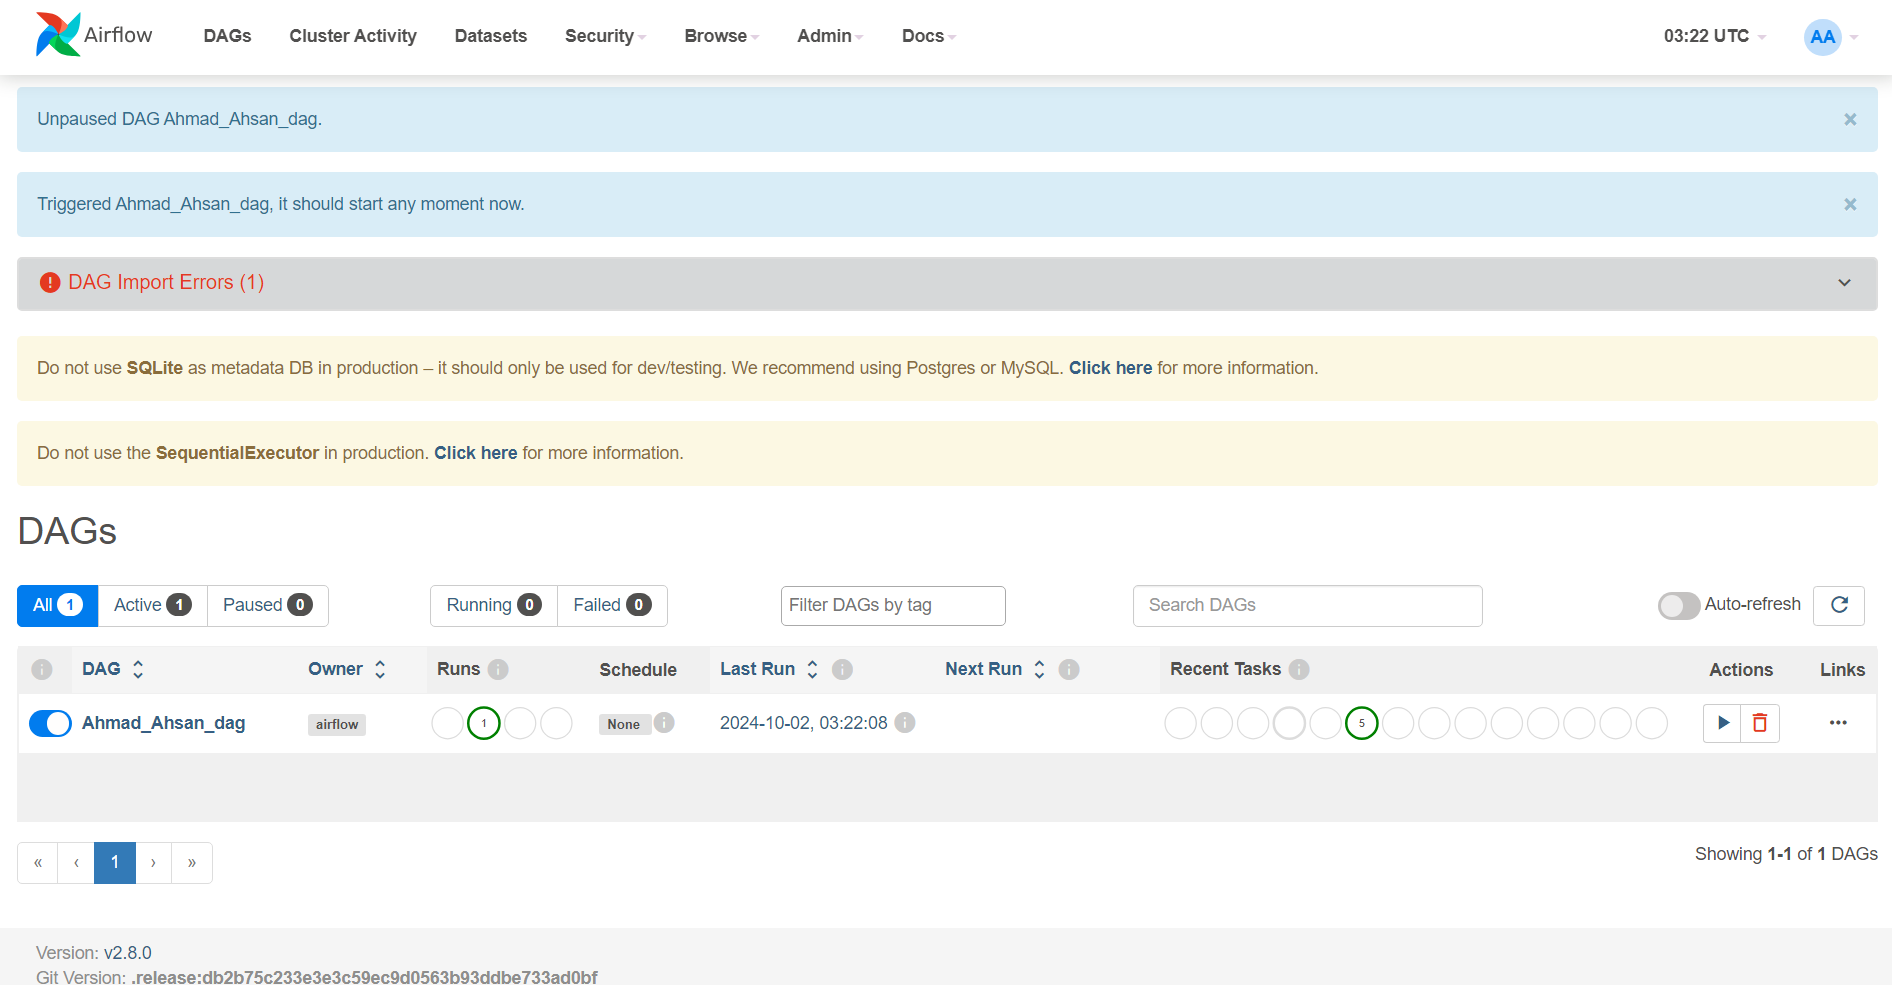

In [92]:
# Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Colab Notebooks/de_lab_5_Ahmad_Ahsan.ipynb" ./
!jupyter nbconvert --to html "de_lab_5_Ahmad_Ahsan.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook de_lab_5_Ahmad_Ahsan.ipynb to html
[NbConvertApp] Writing 1221180 bytes to de_lab_5_Ahmad_Ahsan.html
